In [1]:
import os
import rosbag
import rospy
import tf
import numpy as np
import tf2_ros
import tf2_geometry_msgs


data_already_loaded = False

bag_dir_diff = '../../../dissertation_data/diff_2'
bag_dir_omni = '../../../dissertation_data/omni'

# List all .bag files in the directory
bag_files_diff = sorted([f for f in os.listdir(bag_dir_diff) if f.endswith('.bag')])
bag_files_omni = sorted([f for f in os.listdir(bag_dir_omni) if f.endswith('.bag')])

bag_file_diff_full = [bag_dir_diff + '/' + bag_file for bag_file in bag_files_diff]
bag_file_omni_full = [bag_dir_omni + '/' + bag_file for bag_file in bag_files_omni]

print('Diff:')
for bag_file in bag_file_diff_full:
    print(bag_file)

print('Omni:')
for bag_file in bag_file_omni_full:
    print(bag_file)

Diff:
../../../dissertation_data/diff_2/a_first_perfect.bag
../../../dissertation_data/diff_2/b_second_perfect.bag
../../../dissertation_data/diff_2/c_third_scrach.bag
../../../dissertation_data/diff_2/d_forth.bag
../../../dissertation_data/diff_2/e_fifth.bag
Omni:
../../../dissertation_data/omni/a_first_perfect.bag
../../../dissertation_data/omni/b_second_perfect.bag
../../../dissertation_data/omni/c_third_perfect.bag
../../../dissertation_data/omni/d_forth_perfect.bag
../../../dissertation_data/omni/e_fifth_little_scratch_end.bag


In [2]:
import pandas as pd
import ast

# Read the CSV file
df = pd.read_csv('time_values.csv')

# Function to convert string to list and handle errors
def convert_to_list(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError) as e:
        # print(f"Error converting {x}: {e}")
        return x  # Return original value if conversion fails

# Apply the conversion function to each column
for column in df.columns:
    df[column] = df[column].apply(convert_to_list)

# Print the DataFrame to inspect
print(df)

   Unnamed: 0          diff_go         diff_back         omni_go  \
0           0   [11.06, 95.89]  [129.65, 257.98]    [13.1, 77.7]   
1           1   [12.11, 96.97]  [130.81, 238.91]  [11.61, 73.26]   
2           2  [10.06, 110.98]   [137.2, 253.99]   [11.1, 86.32]   
3           3   [10.1, 100.91]  [145.83, 266.74]  [14.13, 91.38]   
4           4  [10.08, 101.45]  [129.66, 260.13]  [13.58, 81.28]   

          omni_back  
0   [103.4, 173.63]  
1   [109.6, 180.86]  
2  [130.18, 212.62]  
3  [146.93, 253.76]  
4  [109.05, 207.15]  


In [3]:
if not data_already_loaded:
    rospy.init_node('tf_buffer_node', anonymous=True)
    cache_time = rospy.Duration(172800) #Two days
    tf_buffer = tf2_ros.Buffer(cache_time=cache_time)

    go_times_omni = df.iloc[:, 1].values
    back_times_omni = df.iloc[:, 2].values

    go_times_diff = df.iloc[:, 3].values
    back_times_diff = df.iloc[:, 4].values

    # Omni bags
    for i, bag_file in enumerate(bag_file_omni_full):
        bag = rosbag.Bag(bag_file, 'r')
        first_time = None

        go_time_begin = go_times_omni[i][0] - 1 # 1 second before
        go_time_end = go_times_omni[i][1] + 1 # 1 second after
        back_time_begin = back_times_omni[i][0] - 1
        back_time_end = back_times_omni[i][1] + 1

        for topic, msg, t in bag.read_messages(topics=['/tf', '/tf_static', '/vrpn_client_node/L1/pose']):

            if topic == '/tf_static':
                for transform in msg.transforms:
                    tf_buffer.set_transform(transform, 'default_authority')
            
            if first_time is None:
                if topic == '/vrpn_client_node/L1/pose':
                    first_time = t.to_sec()
                else:
                    continue
            
            elapsed_time = t.to_sec() - first_time

            if ((elapsed_time >= go_time_begin) and (elapsed_time <= go_time_end)) or ((elapsed_time >= back_time_begin) and (elapsed_time <= back_time_end)):
                if topic == '/tf':
                    for transform in msg.transforms:
                        tf_buffer.set_transform(transform, 'default_authority')

        bag.close()

    # # Diff bags
    # for i, bag_file in enumerate(bag_file_diff_full):
    #     bag = rosbag.Bag(bag_file, 'r')
    #     first_time = None

    #     go_time_begin = go_times_diff[i][0] - 1
    #     go_time_end = go_times_diff[i][1] + 1
    #     back_time_begin = back_times_diff[i][0] - 1
    #     back_time_end = back_times_diff[i][1] + 1

    #     for topic, msg, t in bag.read_messages(topics=['/tf', '/tf_static', '/vrpn_client_node/L1/pose']):

    #         if topic == '/tf_static':
    #             for transform in msg.transforms:
    #                 tf_buffer.set_transform(transform, 'default_authority')
            
    #         if first_time is None:
    #             if topic == '/vrpn_client_node/L1/pose':
    #                 first_time = t.to_sec()
    #             else:
    #                 continue
            
    #         elapsed_time = t.to_sec() - first_time

    #         if ((elapsed_time >= go_time_begin) and (elapsed_time <= go_time_end)) or ((elapsed_time >= back_time_begin) and (elapsed_time <= back_time_end)):
    #             if topic == '/tf':
    #                 for transform in msg.transforms:
    #                     tf_buffer.set_transform(transform, 'default_authority')

    #     bag.close()

# 3m 28

/tmp/ipykernel_9577/491825911.py:26: UserWarning: translation should be of type Vector3
  tf_buffer.set_transform(transform, 'default_authority')
/tmp/ipykernel_9577/491825911.py:26: UserWarning: rotation should be of type Quaternion
  tf_buffer.set_transform(transform, 'default_authority')
/tmp/ipykernel_9577/491825911.py:39: UserWarning: translation should be of type Vector3
  tf_buffer.set_transform(transform, 'default_authority')
/tmp/ipykernel_9577/491825911.py:39: UserWarning: rotation should be of type Quaternion
  tf_buffer.set_transform(transform, 'default_authority')


In [4]:
if not data_already_loaded:
    # Separate times to cut the data
    go_times = df.iloc[:, 3].values
    back_times = df.iloc[:, 4].values

    poses_omni_go = {}
    poses_omni_back = {}

    base_points_omni_go = {}
    base_points_omni_back = {}

    lidar_omni_go = {}
    lidar_omni_back = {}

    map_omni = {}

    local_map_omni_go = {}
    local_map_omni_back = {}

    local_path_omni_go = {}
    local_path_omni_back = {}

    smoothed_local_path_omni_go = {}
    smoothed_local_path_omni_back = {}

    for i, bag_file in enumerate(bag_file_omni_full):
        go_time_begin = go_times[i][0]
        go_time_end = go_times[i][1]
        back_time_begin = back_times[i][0]
        back_time_end = back_times[i][1]

        bag = rosbag.Bag(bag_file, 'r')
        poses_omni_go[i] = []
        poses_omni_back[i] = []

        base_points_omni_go[i] = []
        base_points_omni_back[i] = []

        lidar_omni_go[i] = []
        lidar_omni_back[i] = []

        map_omni[i] = None

        local_map_omni_go[i] = []
        local_map_omni_back[i] = []

        local_path_omni_go[i] = []
        local_path_omni_back[i] = []

        smoothed_local_path_omni_go[i] = []
        smoothed_local_path_omni_back[i] = []

        first_time = None

        for topic, msg, t in bag.read_messages(topics=['/vrpn_client_node/L1/pose', '/base_points', '/rplidar/scan', '/map', '/local_map', '/local_path', '/smoothed_local_path' ]):
            
            if first_time is None:
                if topic == '/vrpn_client_node/L1/pose':
                    first_time = t.to_sec()
                else:
                    continue
            
            elapsed_time = t.to_sec() - first_time

            if ((elapsed_time >= go_time_begin) and (elapsed_time <= go_time_end)):
                # if topic == '/base_points':
                #     base_points_omni_go[i].append(msg)
                
                if topic == '/rplidar/scan':
                    lidar_omni_go[i].append(msg)
                
                if topic == '/map':
                    map_omni[i] = msg
                
                # if topic == '/local_map':
                #     local_map_omni_go[i].append(msg)
                
                if topic == '/local_path':
                    local_path_omni_go[i].append(msg)
                
                if topic == '/smoothed_local_path':
                    smoothed_local_path_omni_go[i].append(msg)
                
                if topic == '/vrpn_client_node/L1/pose':
                    poses_omni_go[i].append(msg)

            if ((elapsed_time >= back_time_begin) and (elapsed_time <= back_time_end)):
                # if topic == '/base_points':
                #     base_points_omni_back[i].append(msg)
                
                if topic == '/rplidar/scan':
                    lidar_omni_back[i].append(msg)
                
                # if topic == '/local_map':
                #     local_map_omni_back[i].append(msg)
                
                if topic == '/local_path':
                    local_path_omni_back[i].append(msg)
                
                if topic == '/smoothed_local_path':
                    smoothed_local_path_omni_back[i].append(msg)
                
                if topic == '/vrpn_client_node/L1/pose':
                    poses_omni_back[i].append(msg)
        bag.close()

    del go_times, back_times
# 1m

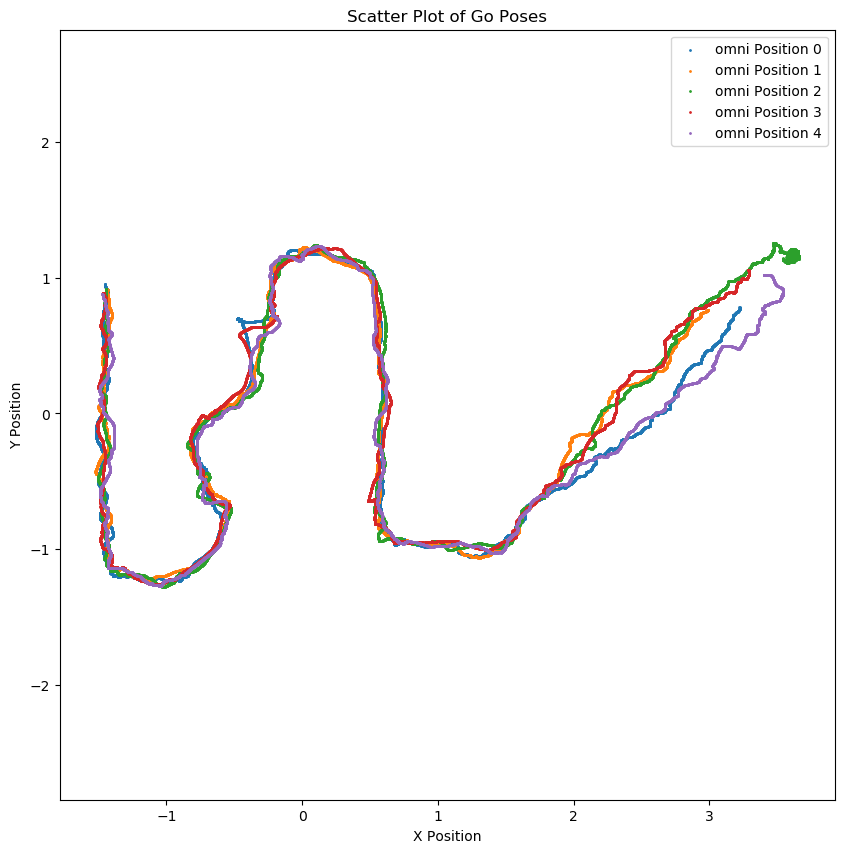

In [5]:
# 6.5cm
import matplotlib.pyplot as plt

# Scatter plot for positions_omni_go
plt.figure(figsize=(10, 10))

for i in poses_omni_go.keys():
    positions = np.array([[pose.pose.position.x, pose.pose.position.y] for pose in poses_omni_go[i]])
    plt.scatter(positions[:, 0], positions[:, 1], label=f'omni Position {i}', s=1)

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.title('Scatter Plot of Go Poses')
plt.legend()
plt.show()

In [6]:

def limit_data_frequency(data, times, max_frequency_hz):
    max_frequency_sec = 1 / max_frequency_hz

    new_data = []
    
    last_time = None
    for i, time in enumerate(times):
        if last_time is None:
            last_time = time
            new_data.append(data[i])
            continue

        dt = time - last_time

        if dt >= max_frequency_sec:
            new_data.append(data[i])
            last_time = time
    
    return new_data


# Limit the frequency of the data
max_frequency_hz = 10
poses_omni_go_filtered = {}
poses_omni_back_filtered = {}

for i in poses_omni_go.keys():
    pose_omni_go_times = [pose.header.stamp.to_sec() for pose in poses_omni_go[i]]
    poses_omni_go_filtered[i] = limit_data_frequency(poses_omni_go[i], pose_omni_go_times, max_frequency_hz)

    pose_omni_back_times = [pose.header.stamp.to_sec() for pose in poses_omni_back[i]]
    poses_omni_back_filtered[i] = limit_data_frequency(poses_omni_back[i], pose_omni_back_times, max_frequency_hz)

In [7]:
if not data_already_loaded:
    # Yaw values in radians
    # Orientations   
    orientations_omni_go_filtered = {}
    orientations_omni_back_filtered = {}
    for i in range(len(poses_omni_go)):
        orientations_omni_go_filtered[i] = []
        orientations_omni_back_filtered[i] = []
        for pose in poses_omni_go_filtered[i]:
            orientation_q = pose.pose.orientation
            orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
            roll, pitch, yaw = tf.transformations.euler_from_quaternion(orientation_list)
            orientations_omni_go_filtered[i].append(yaw)
        for pose in poses_omni_back_filtered[i]:
            orientation_q = pose.pose.orientation
            orientation_list = [orientation_q.x, orientation_q.y, orientation_q.z, orientation_q.w]
            roll, pitch, yaw = tf.transformations.euler_from_quaternion(orientation_list)
            orientations_omni_back_filtered[i].append(yaw)
        
        orientations_omni_go_filtered[i] = np.array(orientations_omni_go_filtered[i])
        orientations_omni_back_filtered[i] = np.array(orientations_omni_back_filtered[i])

In [9]:
angular_velocity_omni_go = {}
angular_acceleration_omni_go = {}

angular_velocity_omni_back = {}
angular_acceleration_omni_back = {}

for i in orientations_omni_go_filtered.keys():
    # Calculate angular velocity (difference in yaw divided by time difference)
    angular_velocity_omni_go[i] = np.diff(orientations_omni_go_filtered[i]) / np.diff([pose.header.stamp.to_sec() for pose in poses_omni_go_filtered[i]])
    
    # Calculate angular acceleration (difference in angular velocity divided by time difference)
    angular_acceleration_omni_go[i] = np.diff(angular_velocity_omni_go[i]) / np.diff([pose.header.stamp.to_sec() for pose in poses_omni_go_filtered[i][1:]])

for i in orientations_omni_back_filtered.keys():
    # Calculate angular velocity (difference in yaw divided by time difference)
    angular_velocity_omni_back[i] = np.diff(orientations_omni_back_filtered[i]) / np.diff([pose.header.stamp.to_sec() for pose in poses_omni_back_filtered[i]])
    
    # Calculate angular acceleration (difference in angular velocity divided by time difference)
    angular_acceleration_omni_back[i] = np.diff(angular_velocity_omni_back[i]) / np.diff([pose.header.stamp.to_sec() for pose in poses_omni_back_filtered[i][1:]])

New sampling rate: 9.648937681347903
New sampling rate: 9.642847342105222
New sampling rate: 9.654233060750931
New sampling rate: 9.650255514826622
New sampling rate: 9.647290766072373


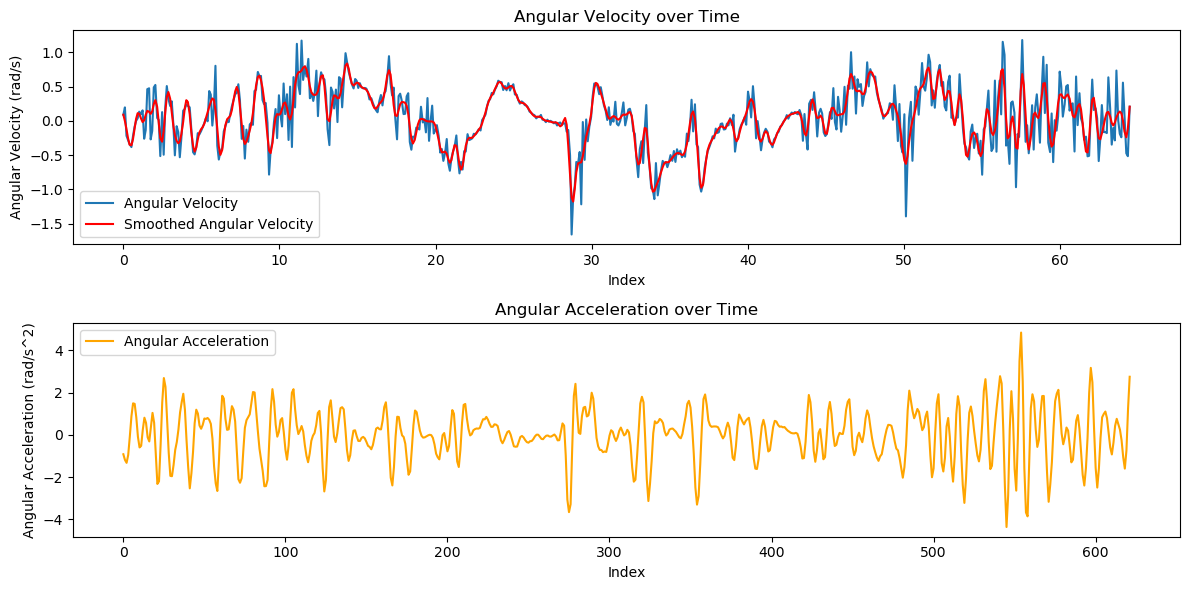

In [10]:
from scipy.signal import butter, filtfilt

def butterworth_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Define thresholds
upper_threshold = 1000
lower_threshold = -1000

# Filter angular velocity
filtered_angular_velocity_omni = {}
smoothed_velocities = {}
elapsed_time = {}
smoothed_accelerations = {}
for i in angular_velocity_omni_go.keys():
    filtered_angular_velocity_omni[i] = np.clip(angular_velocity_omni_go[i], lower_threshold, upper_threshold)

    cutoff_frequency = 1.7
    new_sampling_rate = 1 / np.mean(np.diff([pose.header.stamp.to_sec() for pose in poses_omni_go_filtered[i]]))
    print(f"New sampling rate: {new_sampling_rate}")

    smoothed_velocities[i] = butterworth_filter(filtered_angular_velocity_omni[i], cutoff_frequency, new_sampling_rate)
    elapsed_time[i] = np.array([pose.header.stamp.to_sec() - poses_omni_go_filtered[i][0].header.stamp.to_sec() for pose in poses_omni_go_filtered[i]])
    elapsed_time[i] = elapsed_time[i][:-1]

    smoothed_accelerations[i] = np.diff(smoothed_velocities[i]) / np.diff(elapsed_time[i])

import matplotlib.pyplot as plt

# Plot angular velocity
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(elapsed_time[0], angular_velocity_omni_go[0], label='Angular Velocity')
plt.plot(elapsed_time[0], smoothed_velocities[0], label='Smoothed Angular Velocity', color='red')
plt.xlabel('Index')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Angular Velocity over Time')
plt.legend()

# Plot angular acceleration
plt.subplot(2, 1, 2)
plt.plot(smoothed_accelerations[0], label='Angular Acceleration', color='orange')
plt.xlabel('Index')
plt.ylabel('Angular Acceleration (rad/s^2)')
plt.title('Angular Acceleration over Time')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
import numpy as np

def filter_lidar_scans(lidar_data, elapsed_time, accelerations, velocities, acceleration_threshold=0.4, velocity_threshold=0.15):
    # Calculate the elapsed time for each lidar scan
    lidar_elapsed_time = np.array([lidar.header.stamp.to_sec() - lidar_data[0].header.stamp.to_sec() for lidar in lidar_data])

    filtered_lidar_data = []

    # Iterate through lidar scans and their corresponding elapsed times
    for lidar, time in zip(lidar_data, lidar_elapsed_time):
        # Get the index of the acceleration/velocity value closest to the time of the lidar scan
        index = np.argmin(np.abs(elapsed_time - time))

        # Retrieve the corresponding acceleration and velocity values
        acceleration_value = accelerations[index - 1]
        velocity_value = velocities[index - 1]

        # Apply filtering conditions based on acceleration and velocity thresholds
        if (np.abs(acceleration_value) < acceleration_threshold) and (np.abs(velocity_value) < velocity_threshold):
            filtered_lidar_data.append(lidar)

    return filtered_lidar_data


In [35]:
acceleration_threshold = 0.1
velocity_threshold = 0.15

lidar_omni_go_filtered = {}
for i in range(len(lidar_omni_go)):
    lidar_omni_go_filtered[i] = filter_lidar_scans(lidar_omni_go[i], elapsed_time[i], smoothed_accelerations[i], smoothed_velocities[i], acceleration_threshold, velocity_threshold)

print(len(lidar_omni_go[0]), len(lidar_omni_go_filtered[0]))
print(len(lidar_omni_go[1]), len(lidar_omni_go_filtered[1]))
print(len(lidar_omni_go[2]), len(lidar_omni_go_filtered[2]))
print(len(lidar_omni_go[3]), len(lidar_omni_go_filtered[3]))
print(len(lidar_omni_go[4]), len(lidar_omni_go_filtered[4]))

840 45
803 31
980 18
1010 144
883 14


In [36]:
import copy
import laser_geometry
import tf2_ros
import tf2_sensor_msgs

def transform_laser_scans_to_world_frame(filtered_lidar_scans, tf_buffer, target_frame='world', max_range=6.0):
    """
    Transforms a list of LaserScan messages to the specified world frame and returns the transformed PointCloud2 data.

    Args:
        filtered_lidar_scans (list): List of LaserScan messages to be transformed.
        tf_buffer (tf2_ros.Buffer): TF buffer to lookup transforms.
        target_frame (str): The target frame to transform the data to. Default is 'world'.
        max_range (float): The maximum range to filter LaserScan points. Points greater than max_range will be set to infinity.

    Returns:
        list: List of transformed PointCloud2 messages in the target frame.
    """
    # Create a laser projector object to convert LaserScan to PointCloud2
    projector = laser_geometry.LaserProjection()
    lidar_world_frame = []

    # Iterate over each LaserScan message
    for original_msg in filtered_lidar_scans:
        try:
            # Create a deep copy of the original LaserScan message to avoid modifying it
            msg = copy.deepcopy(original_msg)
            
            # Get the transform from the source frame to the target frame at the message timestamp
            transform = tf_buffer.lookup_transform(target_frame, msg.header.frame_id, msg.header.stamp)

            # Filter out scan messages with ranges greater than max_range (work on the copied data)
            msg.ranges = [r if r <= max_range else float('inf') for r in msg.ranges]

            # Convert LaserScan to PointCloud2 using the laser geometry projector
            cloud = projector.projectLaser(msg)

            # Transform the PointCloud2 to the target frame
            transformed_cloud = tf2_sensor_msgs.do_transform_cloud(cloud, transform)

            # Append the transformed PointCloud2 to the list
            lidar_world_frame.append(transformed_cloud)

        except tf2_ros.LookupException as e:
            print(f"LookupException: {e}")
        except tf2_ros.ExtrapolationException as e:
            print(f"ExtrapolationException: {e}")
        except Exception as e:
            print(f"Transformation failed at time {msg.header.stamp.to_sec()}: {e}")

    return lidar_world_frame

In [37]:
laser_omni_go_filtered_world = {}

for i in range(len(lidar_omni_go_filtered)):
    laser_omni_go_filtered_world[i] = transform_laser_scans_to_world_frame(lidar_omni_go_filtered[i], tf_buffer)

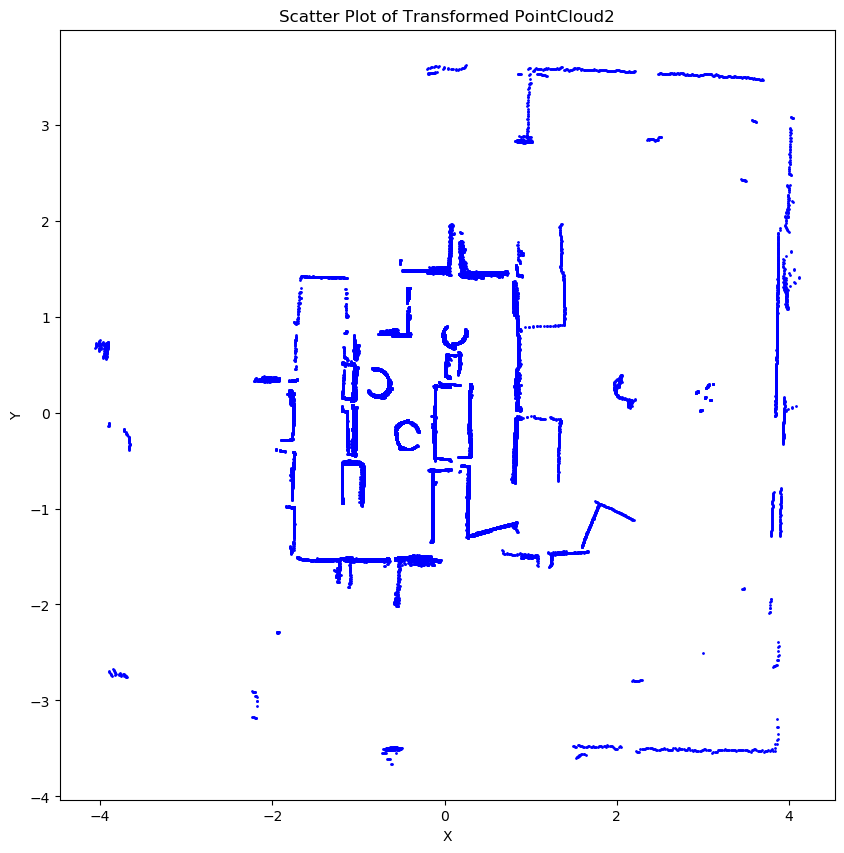

In [38]:
import sensor_msgs.point_cloud2 as pc2
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for transformed_cloud in laser_omni_go_filtered_world[3]:
    # Read the points from the PointCloud2 message
    points = list(pc2.read_points(transformed_cloud, field_names=("x", "y", "z"), skip_nans=True))

    # Convert to numpy array for easier manipulation
    points_array = np.array(points)

    # Scatter plot the points
    plt.scatter(points_array[:, 0], points_array[:, 1], c='blue', s=1)
    
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Transformed PointCloud2')
plt.show()